In [1]:
from src.conv_seq2seq import *
from src.utils import *
from src.layers import MaskedCrossEntropyLoss
import torch 
import torch.optim as optim
import random

# Setup

In [96]:
# OPTIONS: 
# ENGLISH - en, 
# GERMAN - de, 
# FRENCH - fr, 
# CZECH - cs

lang1 = 'de'
lang2 = 'en'

train_sentences, test_sentences = load_data(lang1, lang2)
train_sentences = (train_sentences[0][:500], train_sentences[1][:500])

In [97]:
TEST_SIZE=0.2
BATCH_SIZE=64
VALID_BATCH_SIZE=128
MAX_VOCAB=20000

src_vocab, tgt_vocab, train_loader, valid_loader = make_dataset(train_sentences, test_sentences, BATCH_SIZE, VALID_BATCH_SIZE, MAX_VOCAB)

In [98]:
print(f"Number of training examples: {len(train_loader.dataset)}")
print(f"Number of validation examples: {len(valid_loader.dataset)}")
print(f"Training Batches {len(train_loader)}\tValidation Batches {len(valid_loader)}")

Number of training examples: 500
Number of validation examples: 1014
Training Batches 8	Validation Batches 8


In [99]:
print(f"Unique tokens in source ({lang1}) vocabulary: {len(src_vocab)}")
print(f"Unique tokens in target ({lang2}) vocabulary: {len(tgt_vocab)}")

Unique tokens in source (de) vocabulary: 1348
Unique tokens in target (en) vocabulary: 1224


# Make the Model

In [100]:
# ENCODER ARGS
ENC_UNITS = 128 # 512
ENC_EMBEDDING = 256 # 256
SRC_VOCAB_SIZE = len(src_vocab)
ENC_NUM_LAYERS = 3 # 10
ENC_KERNEL_SIZE = 3 # ODD
DROPOUT = 0.25

# DECODER ARGS
DEC_UNITS = ENC_UNITS
DEC_EMBEDDING = ENC_EMBEDDING
TGT_VOCAB_SIZE = len(tgt_vocab)
DEC_NUM_LAYERS = ENC_NUM_LAYERS
DEC_KERNEL_SIZE = 3 # EVEN OR ODD
PAD_IDX = tgt_vocab.PAD_token


# SEQ2SEQ ARGS
MAX_LENGTH = 50
SOS_TOKEN = tgt_vocab.SOS_token

In [101]:
encoder = Encoder(SRC_VOCAB_SIZE, ENC_EMBEDDING, ENC_UNITS, ENC_NUM_LAYERS, ENC_KERNEL_SIZE, DROPOUT, MAX_LENGTH)
decoder = Decoder(DEC_UNITS, DEC_EMBEDDING, TGT_VOCAB_SIZE, DEC_NUM_LAYERS, DEC_KERNEL_SIZE, DROPOUT, PAD_IDX, MAX_LENGTH)

seq2seq = Seq2Seq(encoder, decoder, MAX_LENGTH, SOS_TOKEN)

print(f'The model has {count_parameters(seq2seq):,} trainable parameters')

The model has 1,787,720 trainable parameters


In [102]:
print(seq2seq)

Seq2Seq(
  (encoder): Encoder(
    (token_embedding): Embedding(1348, 256)
    (position_embedding): Embedding(50, 256)
    (embed2hidden): Linear(in_features=256, out_features=128, bias=True)
    (hidden2embed): Linear(in_features=128, out_features=256, bias=True)
    (convs): Sequential(
      (0): EncoderConv(
        (conv): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
        (dropout): Dropout(p=0.25, inplace=False)
      )
      (1): EncoderConv(
        (conv): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
        (dropout): Dropout(p=0.25, inplace=False)
      )
      (2): EncoderConv(
        (conv): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
        (dropout): Dropout(p=0.25, inplace=False)
      )
    )
    (dropout): Dropout(p=0.25, inplace=False)
  )
  (decoder): Decoder(
    (token_embedding): Embedding(1224, 256)
    (position_embedding): Embedding(50, 256)
    (embedd2hidden): Linear(in_features=256, out_features=128,

In [103]:
criterion = MaskedCrossEntropyLoss(pad_tok=tgt_vocab.PAD_token)
optimizer = optim.Adam(seq2seq.parameters())

# Train

In [104]:
# valid_loss = evaluate(seq2seq, valid_loader, criterion)

In [105]:
# valid_loss

In [106]:
idx = 55
src_sentence = train_loader.dataset.tensors[0][idx:idx+1][:, :20]
tgt_sentence = train_loader.dataset.tensors[1][idx:idx+1][:, :20]
print(src_sentence[:, :19])
print(tgt_sentence[:, :21])
print(src_sentence.size(), tgt_sentence.size())
print(src_vocab.to_string(src_sentence))
print(tgt_vocab.to_string(tgt_sentence))

tensor([[  2,   5,  12,   8,   7, 177,  70,  26,  19, 117, 579, 148,   6,  16,
         300,  18, 177, 151,   3]])
tensor([[  3,   2,   9,   6,   2, 139,  10,  77, 345,  16, 135, 592,  14, 317,
          81,   6,   2, 139,   5,   4]])
torch.Size([1, 20]) torch.Size([1, 20])
['<sos> ein mann in einem anzug rennt an zwei anderen herren vorbei , die auch einen anzug tragen . <eos>']
['<sos> a man in a suit is running past two other gentleman , also dressed in a suit . <eos>']


In [107]:
out, attention = seq2seq(src_sentence)

In [108]:
out.size(), attention.size()

(torch.Size([1, 50, 1224]), torch.Size([1, 50, 20]))

In [109]:
translation = tgt_vocab.to_string(out.argmax(dim=-1))[0]
translation

'says mouth dusk too firetrucks trophy vest high watches rest blond-hair container swim shows orange observes chalk carpentry tribal gazing goggles paint thumb tattoo plain house horses approaching marlins dressed beer load silly automobile jeans steps softball sit display she safety inside its secures part mound jeans conversation bird paintbrush'

In [200]:
N_EPOCHS = 50
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    print(f'Epoch: {epoch+1:02}')
    
    train_loss = train(seq2seq, train_loader, optimizer, criterion, CLIP, src_vocab.PAD_token)
    valid_loss = evaluate(seq2seq, train_loader, criterion)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(seq2seq.state_dict(), 'models/seq2seq_attention.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')


Epoch: 01

100%|██████████| 8/8 [00:01<00:00,  7.04it/s]	Train Loss: 1.293 | Train PPL:   3.645
	 Val. Loss: 0.648 |  Val. PPL:   1.912
Epoch: 02

100%|██████████| 8/8 [00:01<00:00,  6.62it/s]	Train Loss: 1.289 | Train PPL:   3.630
	 Val. Loss: 0.646 |  Val. PPL:   1.909
Epoch: 03

100%|██████████| 8/8 [00:01<00:00,  6.58it/s]	Train Loss: 1.283 | Train PPL:   3.606
	 Val. Loss: 0.641 |  Val. PPL:   1.899
Epoch: 04

100%|██████████| 8/8 [00:01<00:00,  6.77it/s]	Train Loss: 1.272 | Train PPL:   3.569
	 Val. Loss: 0.641 |  Val. PPL:   1.899
Epoch: 05

100%|██████████| 8/8 [00:01<00:00,  6.54it/s]	Train Loss: 1.262 | Train PPL:   3.533
	 Val. Loss: 0.629 |  Val. PPL:   1.876
Epoch: 06

100%|██████████| 8/8 [00:01<00:00,  6.57it/s]	Train Loss: 1.243 | Train PPL:   3.466
	 Val. Loss: 0.628 |  Val. PPL:   1.873
Epoch: 07

100%|██████████| 8/8 [00:01<00:00,  6.32it/s]	Train Loss: 1.264 | Train PPL:   3.541
	 Val. Loss: 0.627 |  Val. PPL:   1.871
Epoch: 08

100%|██████████| 8/8 [00:01<00:00,  5

100%|██████████| 8/8 [00:01<00:00,  6.60it/s]	Train Loss: 1.283 | Train PPL:   3.608
	 Val. Loss: 0.617 |  Val. PPL:   1.854
Epoch: 10

100%|██████████| 8/8 [00:01<00:00,  6.43it/s]	Train Loss: 1.241 | Train PPL:   3.461
	 Val. Loss: 0.614 |  Val. PPL:   1.848
Epoch: 11

100%|██████████| 8/8 [00:01<00:00,  6.48it/s]	Train Loss: 1.244 | Train PPL:   3.470
	 Val. Loss: 0.602 |  Val. PPL:   1.826
Epoch: 12

100%|██████████| 8/8 [00:01<00:00,  6.50it/s]	Train Loss: 1.214 | Train PPL:   3.365
	 Val. Loss: 0.600 |  Val. PPL:   1.821
Epoch: 13

100%|██████████| 8/8 [00:01<00:00,  6.48it/s]	Train Loss: 1.219 | Train PPL:   3.385
	 Val. Loss: 0.602 |  Val. PPL:   1.825
Epoch: 14

100%|██████████| 8/8 [00:01<00:00,  6.51it/s]	Train Loss: 1.228 | Train PPL:   3.416
	 Val. Loss: 0.596 |  Val. PPL:   1.816
Epoch: 15

100%|██████████| 8/8 [00:01<00:00,  6.49it/s]	Train Loss: 1.231 | Train PPL:   3.423
	 Val. Loss: 0.591 |  Val. PPL:   1.805
Epoch: 16

100%|██████████| 8/8 [00:01<00:00,  6.49it/s]	Tr

100%|██████████| 8/8 [00:01<00:00,  6.51it/s]	Train Loss: 1.228 | Train PPL:   3.415
	 Val. Loss: 0.588 |  Val. PPL:   1.800
Epoch: 19

100%|██████████| 8/8 [00:01<00:00,  6.57it/s]	Train Loss: 1.200 | Train PPL:   3.321
	 Val. Loss: 0.582 |  Val. PPL:   1.790
Epoch: 20

100%|██████████| 8/8 [00:01<00:00,  6.76it/s]	Train Loss: 1.207 | Train PPL:   3.342
	 Val. Loss: 0.576 |  Val. PPL:   1.780
Epoch: 21

100%|██████████| 8/8 [00:01<00:00,  6.59it/s]	Train Loss: 1.188 | Train PPL:   3.279
	 Val. Loss: 0.575 |  Val. PPL:   1.777
Epoch: 22

100%|██████████| 8/8 [00:01<00:00,  6.46it/s]	Train Loss: 1.168 | Train PPL:   3.216
	 Val. Loss: 0.572 |  Val. PPL:   1.771
Epoch: 23

100%|██████████| 8/8 [00:01<00:00,  6.59it/s]	Train Loss: 1.173 | Train PPL:   3.233
	 Val. Loss: 0.569 |  Val. PPL:   1.767
Epoch: 24

100%|██████████| 8/8 [00:01<00:00,  6.85it/s]	Train Loss: 1.205 | Train PPL:   3.336
	 Val. Loss: 0.574 |  Val. PPL:   1.776
Epoch: 25

100%|██████████| 8/8 [00:01<00:00,  6.83it/s]	Tr

100%|██████████| 8/8 [00:01<00:00,  6.09it/s]	Train Loss: 1.190 | Train PPL:   3.286
	 Val. Loss: 0.566 |  Val. PPL:   1.761
Epoch: 27

 25%|██▌       | 2/8 [00:04<00:12,  2.02s/it]

KeyboardInterrupt: 

In [204]:
def evaluate_translate(model, iterator, criterion, pad_tok=0):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for i, (src, tgt) in enumerate(tqdm(iterator, file=sys.stdout)):
            # src.shape = (batch_size, src_seq_len)
            # tgt.shape = (batch_size, tgt_seq_len)
            src_mask = create_padding_mask(src, pad_tok)

            if model.type == 'rnn':
                output, attention = model(src, None, src_mask) #turn off teacher forcing
                # output.shape == (batch_size, max_length, tgt_vocab_size)
                # print(output)
                # output = output[:, 1:, :]
                tgt = tgt[:, 1:]
            elif model.type == 'conv':
                output, attention = model(src, None) #turn off teacher forcing
                tgt = tgt[:, 1:]

            loss = criterion(output, tgt) # masked loss automatically slices for you

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [205]:
valid_loss = evaluate_translate(seq2seq, train_loader, criterion)



  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:03<00:26,  3.78s/it]

 25%|██▌       | 2/8 [00:07<00:22,  3.71s/it]

 38%|███▊      | 3/8 [00:10<00:18,  3.66s/it]

 50%|█████     | 4/8 [00:15<00:15,  3.84s/it]

 62%|██████▎   | 5/8 [00:18<00:11,  3.76s/it]

 75%|███████▌  | 6/8 [00:22<00:07,  3.69s/it]

 88%|████████▊ | 7/8 [00:25<00:03,  3.60s/it]

100%|██████████| 8/8 [00:28<00:00,  3.40s/it]

In [213]:
valid_loss

10.921553373336792

In [223]:
idx = 423

src_sentence = train_loader.dataset.tensors[0][idx:idx+1]
tgt_sentence = train_loader.dataset.tensors[1][idx:idx+1]

src_sentence = src_vocab.to_string(src_sentence, remove_special=True)[0]
tgt_sentence = tgt_vocab.to_string(tgt_sentence, remove_special=True)[0]

In [224]:
translation, attention = translate(src_sentence, seq2seq, src_vocab, tgt_vocab, src_vocab.PAD_token)

tensor([[   2,    5,   12,   13,   14, 1204,   23,  132,    7,  289,   13, 1205,
          472,    7, 1206,    3,    4]])
tensor([[   2,    9,    6,    2,  520,   31,   10,   39,   52,  977,  205,   45,
            5,    4,    5,    4,    5,    4,    5,    4,    5,    4,    4,    5,
            4,  229,    5,    4,  138,   67,  849,   62,   63,    6,  850,    5,
            4,   13,    2, 1133,    5,    4,    8,    2,   33,   76,   10,   39,
           52,    2]])


In [225]:
print(f"> {src_sentence}")
print(f"= {tgt_sentence}")
print(f"< {translation}")

> ein mann mit einer mistgabel steht bei einem eimer mit zweigen gegenuber einem apartmentkomplex .
= a man with a pitchfork stands near a bucket of branches across from an apartment complex .
< a man in a neon shirt is walking through knee-high ocean water . . . . . . read . looks up he apos s in midsentence . with a leash . on a red jacket is walking through a


In [210]:
src_vocab.PAD_token

0

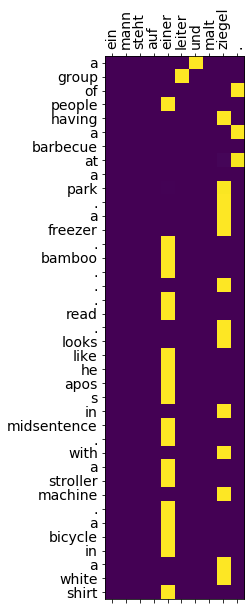

In [211]:
plot_attention(attention, src_sentence, translation)

In [212]:
attention

tensor([[3.1214e-20, 1.0480e-21, 3.6332e-13, 2.7545e-16, 5.9745e-26, 4.8613e-13,
         1.0000e+00, 3.7430e-25, 2.3150e-27, 1.9758e-43],
        [1.2310e-20, 1.8418e-18, 2.9013e-24, 7.4293e-16, 1.0493e-32, 1.0000e+00,
         1.0124e-07, 3.7841e-11, 1.5389e-26, 1.3979e-15],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.9636e-33, 4.0638e-44,
         0.0000e+00, 0.0000e+00, 2.1846e-42, 1.0000e+00],
        [5.1848e-44, 0.0000e+00, 4.1447e-34, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         2.3537e-31, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 2.2835e-37, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [1.5445e-36, 2.1874e-40, 0.0000e+00, 3.5763e-40, 0.0000e+00, 5.1371e-15,
         5.3815e-34, 1.3455e-20, 1.7050e-39, 5.2546e-26],
        [0.0000e+00, 0.0000

In [ ]:
# valid_loss = evaluate(seq2seq, valid_loader, criterion)